# Solar Power Generation Trends

In [13]:
import pandas as pd

path = 'solar_2014-2023.csv'
df = pd.read_csv(path, 
                 index_col=0,
                 )
df.index = pd.to_datetime(df.index, utc=True)

df = df.tz_convert('Europe/Madrid')
df = df.resample('1h').mean()
df

,Solar fotovoltaica
datetime_utc,
2014-01-01 00:00:00+01:00,13.600
2014-01-01 01:00:00+01:00,13.300
2014-01-01 02:00:00+01:00,13.300
2014-01-01 03:00:00+01:00,12.200
2014-01-01 04:00:00+01:00,7.800
...,...
2023-10-01 19:00:00+02:00,2123.425
2023-10-01 20:00:00+02:00,194.450
2023-10-01 21:00:00+02:00,17.800


In [14]:
s_solar = df.loc[:'2022', 'Solar fotovoltaica']
s_solar_monthly = s_solar.resample('ME').sum()
s_solar

datetime_utc
2014-01-01 00:00:00+01:00    13.6
2014-01-01 01:00:00+01:00    13.3
2014-01-01 02:00:00+01:00    13.3
2014-01-01 03:00:00+01:00    12.2
2014-01-01 04:00:00+01:00     7.8
                             ... 
2022-12-31 19:00:00+01:00     5.7
2022-12-31 20:00:00+01:00     3.6
2022-12-31 21:00:00+01:00     2.2
2022-12-31 22:00:00+01:00     1.7
2022-12-31 23:00:00+01:00     1.6
Freq: h, Name: Solar fotovoltaica, Length: 78888, dtype: float64

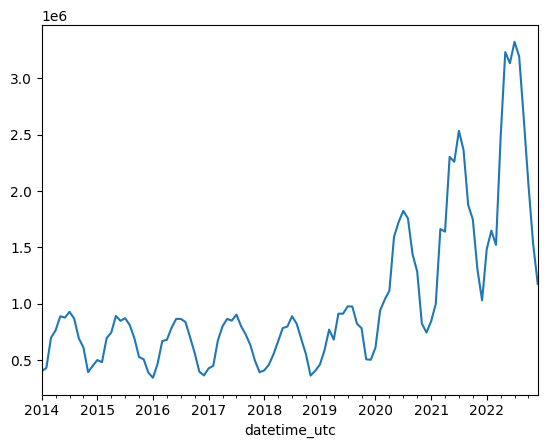

In [15]:
s_solar_monthly.plot.line();

## Multiplicative Model

$y_t = T_t \times S_t \times e_t$

In [16]:
df_solar = s_solar_monthly.to_frame(name='generation')
df_solar

,generation
datetime_utc,
2014-01-31 00:00:00+01:00,402856.200
2014-02-28 00:00:00+01:00,431246.400
2014-03-31 00:00:00+02:00,699283.900
2014-04-30 00:00:00+02:00,765308.000
2014-05-31 00:00:00+02:00,889022.100
...,...
2022-08-31 00:00:00+02:00,3191364.099
2022-09-30 00:00:00+02:00,2636219.180
2022-10-31 00:00:00+01:00,2056758.870


In [17]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='multiplicative', period=12)

df_component = (df_solar
                    .assign(
                        trend = result.trend,
                        seasonal = result.seasonal,
                        residual = result.resid)
                    .dropna())

df_component['component_all'] = df_component.trend * df_component.seasonal * df_component.residual
df_component

,generation,trend,seasonal,residual,component_all
datetime_utc,,,,,
2014-07-31 00:00:00+02:00,928878.300,6.720014e+05,1.391756,0.993175,928878.300
2014-08-31 00:00:00+02:00,868469.700,6.782240e+05,1.297704,0.986747,868469.700
2014-09-30 00:00:00+02:00,693511.100,6.801873e+05,1.073254,0.949997,693511.100
2014-10-31 00:00:00+01:00,613785.400,6.791830e+05,0.914528,0.988173,613785.400
2014-11-30 00:00:00+01:00,394068.200,6.784604e+05,0.648951,0.895025,394068.200
...,...,...,...,...,...
2022-02-28 00:00:00+01:00,1648478.100,2.129337e+06,0.756666,1.023139,1648478.100
2022-03-31 00:00:00+02:00,1521992.800,2.195547e+06,0.974395,0.711435,1521992.800
2022-04-30 00:00:00+02:00,2475835.900,2.240085e+06,1.065528,1.037272,2475835.900


In [18]:
import plotly.express as px

fig = px.area(x=df_solar.index, 
              y=df_solar['generation'], 
              title='Original Time Series',
              )
fig

In [19]:
dff = df_component.melt(ignore_index=False)
dff = dff.query('~variable.isin(["generation", "component_all"])')

fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Multiplicative Model: Components of Time Series', facet_col_spacing=0.05)
fig = fig.update_yaxes(matches=None)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True

fig

## Additive Model

$y_t = T_t + S_t + e_t$

In [20]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='additive', period=12)

df_component = (df_solar
                    .assign(
                        trend = result.trend,
                        seasonal = result.seasonal,
                        residual = result.resid)
                    .dropna())

df_component['component_sum'] = df_component.trend + df_component.seasonal + df_component.residual
df_component

,generation,trend,seasonal,residual,component_sum
datetime_utc,,,,,
2014-07-31 00:00:00+02:00,928878.300,6.720014e+05,353437.131770,-96560.210937,928878.300
2014-08-31 00:00:00+02:00,868469.700,6.782240e+05,271787.442187,-81541.779687,868469.700
2014-09-30 00:00:00+02:00,693511.100,6.801873e+05,61841.589062,-48517.826562,693511.100
2014-10-31 00:00:00+01:00,613785.400,6.791830e+05,-67928.927605,2531.327605,613785.400
2014-11-30 00:00:00+01:00,394068.200,6.784604e+05,-328736.811115,44344.598615,394068.200
...,...,...,...,...,...
2022-02-28 00:00:00+01:00,1648478.100,2.129337e+06,-246269.974704,-234589.189588,1648478.100
2022-03-31 00:00:00+02:00,1521992.800,2.195547e+06,-74768.379282,-598786.067468,1521992.800
2022-04-30 00:00:00+02:00,2475835.900,2.240085e+06,60382.687645,175368.246855,2475835.900


In [21]:
import plotly.express as px

In [22]:
px.area(data_frame=df_component, 
        x=df_component.index, 
        y='generation',
        )

In [23]:
dff = df_component.drop(columns=['generation', 'component_sum'])
dff = dff.melt(ignore_index=False)

In [24]:
fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Additive Model: Components of Time Series', facet_col_spacing=0.05)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True
        
fig